# Sg Housing 

The first step would be to acquire data from https://www.99.co/singapore/sale where porperties in Singapore are listed for sale. 

The features of houses that I web scraped included the listing name, the address code, the number of bedrooms and bathrooms, year built, tenure, property type, mrt distance, squarefeet and price.

## Web scraping 

In [1]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import math
import seaborn as sns

More deails about the webscrape can be found in the other 'webscrape.ipynb'.

In [2]:
def Scrape(start_page,end_page,file_name): #End page is not inclusive
    names,addresses,beds,baths,year_built,tenure,property_type,mrt,price,sqft = [],[],[],[],[],[],[],[],[],[]
    housing = ['HDB','HDB 2 Rooms','HDB 3 Rooms','HDB 4 Rooms','HDB 5 Rooms','HDB Executive','Condo','Apartment','Walk-up','Landed','Executive Condo','Terraced House','Corner Terrace','Semi-Detached','Bungalow','Good Class Bungalow','Cluster House']
    chrome_options = webdriver.ChromeOptions()
    for num in range(start_page,end_page):
        driver = webdriver.Chrome("chromedriver.exe")
        driver.implicitly_wait(5)
        driver.get('https://www.99.co/singapore/sale?page_num={}'.format(num))
        time.sleep(3)
        links =[]

        soup=BeautifulSoup(driver.page_source, 'lxml')
        for link in soup.find_all('a'):
            if type(link.get('href'))==str and 'Search' in link.get('href') and 'page_num'not in link.get('href'):

                links.append('https://www.99.co'+link.get('href'))


        for c,i in enumerate(links): 

            driver.get(i)
            time.sleep(1.5)
            soup=BeautifulSoup(driver.page_source, 'lxml')
            name = soup.find('h1', attrs={'class': '_3Wogd JMF8h lFqTi _1vzK2'})
            names.append(name.getText())


            address = soup.find_all('p', attrs={'class': 'dniCg _3j72o _2rhE-'})
            a = []
            for i in address:
                a.append(i.getText())
            addresses.append(re.findall('(\(D\d\d\)|\(D\d\))',''.join(a)))

            bed = soup.find_all('p', attrs={'class': '_2sIc2 _29qfj _2rhE-'})
            temp1 = ['NA','NA','NA']
            for i in bed:
                if 'Bed'in i.getText().split() or 'Beds' in i.getText().split():
                    temp1[0]=i.getText().split()[0]

                elif 'Bath' in i.getText().split() or 'Baths' in i.getText().split():
                    temp1[1]=i.getText().split()[0]

                elif 'sqft' in i.getText().split():
                    temp1[2]=i.getText().split()[0]
                elif 'Studio' in i.getText().split():
                    temp1[0]=i.getText()            
                else:
                    print('Please maunually get info for page{} and link with index {}'.format(num,c))

            beds.append(temp1[0])
            baths.append(temp1[1])
            sqft.append(temp1[2])


            info = soup.find_all('div', attrs={'class': '_3r4yN XCAFU'})
            temp = ['NA','NA','NA']

            for i in info:
                if 'year' in i.getText().lower():
                    temp[0]=i.getText()[:2]
                elif 'Freehold' in i.getText():
                    temp[0]=i.getText()
                elif re.findall('\d\d\d\d',i.getText())!=[]:
                    temp[1]=i.getText()
                elif i.getText() in housing:
                    temp[2]=i.getText()   
            tenure.append(temp[0])
            year_built.append(temp[1])
            property_type.append(temp[2])

            mrts = soup.find_all('p', attrs={'class': '_2sIc2 _2rhE- _1c-pJ'})
            temp2 = ['NA']
            for i in mrts:
                if re.findall('\(\d+ m\)',''.join(i.getText()))!=[]:
                        temp2[0]=re.findall('\(\d+ m\)',''.join(i.getText()))
            mrt.append(temp2[0])



            prices = soup.find('h2', attrs={'class': '_1zGm8 _3na6W _1vzK2'})
            price.append(prices.getText()[1:])

        if len(names)==len(addresses) and len(addresses)==len(beds) and len(beds)==len(baths) and len(baths)==len(year_built) and len(year_built)==len(tenure) and len(tenure)==len(property_type) and len(property_type)==len(mrt) and len(mrt)==len(price):
            print('All good for page number {}!'.format(num))
        else:
            print('shit, houston we have a problem!')
            break
        driver.close()
    data=pd.DataFrame(names,columns=['title'])
    data['address_code']=addresses
    data['beds']=beds
    data['baths']=baths
    data['year_built']=year_built
    data['tenure']=tenure
    data['property_type']=property_type
    data['mrt_distance']=mrt
    data['sqft']=sqft
    data['price']=price
    data.to_csv(file_name)
    print('Scraped Successfully! :)')

### Compiling scraped data

In [93]:
data_list = []
c=1
for i in range(17):
    data_list.append(pd.read_csv('scraped_pg{}_pg{}.csv'.format(c,c+9)))
    c+=10
data = pd.concat(data_list)
data.head()

Unnamed: 0                                         title address_code beds  \
0           0          HDB Flat for Sale in 110A Depot Road     ['(D4)']    3   
1           1   HDB Flat for Sale in 208B Clementi Avenue 6     ['(D5)']    2   
2           2    HDB Flat for Sale in 560 Hougang Street 51    ['(D19)']    4   
3           3    HDB Flat for Sale in 322C Anchorvale Drive    ['(D19)']    3   
4           4  HDB Flat for Sale in 225 Ang Mo Kio Avenue 1    ['(D20)']    2   

   baths year_built tenure property_type mrt_distance   sqft    price  
0    3.0        NaN     99           HDB          NaN    990  730,000  
1    2.0        NaN    NaN   HDB 3 Rooms  ['(906 m)']    731  610,000  
2    2.0       1999     99           HDB  ['(438 m)']  1,539  768,000  
3    2.0       2002     99           HDB  ['(369 m)']  1,184  558,888  
4    2.0       1978    NaN   HDB 3 Rooms          NaN    882  375,000

In [94]:
data1 = pd.read_csv('scraped_pg171_pg200.csv')
data2 = pd.read_csv('scraped_pg201_pg228.csv')
data_final = pd.concat([data,data1,data2])
data_final

Unnamed: 0                                          title address_code  \
0             0           HDB Flat for Sale in 110A Depot Road     ['(D4)']   
1             1    HDB Flat for Sale in 208B Clementi Avenue 6     ['(D5)']   
2             2     HDB Flat for Sale in 560 Hougang Street 51    ['(D19)']   
3             3     HDB Flat for Sale in 322C Anchorvale Drive    ['(D19)']   
4             4   HDB Flat for Sale in 225 Ang Mo Kio Avenue 1    ['(D20)']   
..          ...                                            ...          ...   
975         975             2 Bed Condo for Sale in Whitehaven     ['(D5)']   
976         976         3 Bed House for Sale in Sennett Estate    ['(D13)']   
977         977       3 Bed EC for Sale in Citylife @ Tampines    ['(D18)']   
978         978     5 Bed Condo for Sale in Hillion Residences    ['(D23)']   
979         979  5 Bed Condo for Sale in Affinity At Serangoon    ['(D19)']   

    beds  baths year_built    tenure    property_type  mrt_distance   sqft  \
0      3    3.0        NaN        99              HDB           NaN    990   
1      2    2.0        NaN       NaN      HDB 3 Rooms   ['(906 m)']    731   
2      4    2.0       1999        99              HDB   ['(438 m)']  1,539   
3      3    2.0       2002        99              HDB   ['(369 m)']  1,184   
4      2    2.0       1978       NaN      HDB 3 Rooms           NaN    882   
..   ...    ...        ...       ...              ...           ...    ...   
975    2    2.0       2017  Freehold        Apartment  ['(2460 m)']    538   
976    3    2.0        NaN  Freehold   Corner Terrace   ['(548 m)']  3,179   
977    3    3.0       2016        99  Executive Condo  ['(1128 m)']  1,216   
978    5    3.0       2018        99            Condo    ['(58 m)']  2,616   
979    5    5.0       2024        99            Condo           NaN  2,303   

         price  
0      730,000  
1      610,000  
2      768,000  
3      558,888  
4      375,000  
..         ...  
975    960,000  
976  4,500,000  
977  1,350,000  
978  3,029,000  
979  2,613,000  

[7980 rows x 11 columns]

In [95]:
data_final.drop('Unnamed: 0',axis=1,inplace=True)

In [96]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          7980 non-null   object 
 1   address_code   7980 non-null   object 
 2   beds           7974 non-null   object 
 3   baths          7414 non-null   float64
 4   year_built     7385 non-null   object 
 5   tenure         7475 non-null   object 
 6   property_type  7751 non-null   object 
 7   mrt_distance   6027 non-null   object 
 8   sqft           7980 non-null   object 
 9   price          7980 non-null   object 
dtypes: float64(1), object(9)
memory usage: 685.8+ KB


In [97]:
data_final.to_csv('compiled_data.csv')

In [3]:
data_final = pd.read_csv('compiled_data.csv',index_col=0)

### Visualize missing data

<AxesSubplot:>

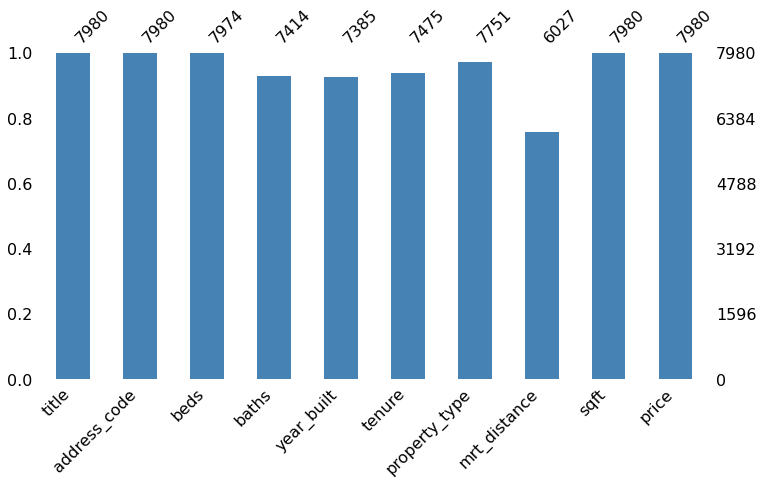

In [4]:
msno.bar(data_final, figsize=(12,6),color='steelblue')

There is a few missing data and we will attempt to clean the columns and peform some feature engineering.

In [5]:
data_final=data_final.drop_duplicates()

In [6]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5271 non-null   object 
 1   address_code   5271 non-null   object 
 2   beds           5265 non-null   object 
 3   baths          4871 non-null   float64
 4   year_built     4856 non-null   object 
 5   tenure         4898 non-null   object 
 6   property_type  5115 non-null   object 
 7   mrt_distance   3984 non-null   object 
 8   sqft           5271 non-null   object 
 9   price          5271 non-null   object 
dtypes: float64(1), object(9)
memory usage: 453.0+ KB


##### Cleaning address code column

In [4]:
data_final['address_code'].value_counts()

['(D19)']    680
['(D10)']    438
['(D15)']    373
['(D9)']     345
['(D18)']    331
['(D5)']     327
['(D3)']     313
['(D14)']    236
['(D23)']    216
['(D4)']     197
['(D16)']    168
['(D11)']    158
['(D12)']    144
['(D27)']    139
['(D1)']     137
['(D2)']     135
['(D21)']    132
['(D28)']    132
['(D13)']    122
['(D20)']    121
['(D22)']     93
['(D7)']      90
['(D17)']     83
['(D8)']      78
['(D25)']     60
['(D26)']     21
['(D6)']       2
Name: address_code, dtype: int64

Extracting the D and numbers

In [7]:
data_final['address_code']=data_final['address_code'].apply(lambda x: re.findall('D\d+',x)[0])

In [6]:
data_final['address_code'].value_counts()

D19    680
D10    438
D15    373
D9     345
D18    331
D5     327
D3     313
D14    236
D23    216
D4     197
D16    168
D11    158
D12    144
D27    139
D1     137
D2     135
D28    132
D21    132
D13    122
D20    121
D22     93
D7      90
D17     83
D8      78
D25     60
D26     21
D6       2
Name: address_code, dtype: int64

###### Cleaning the beds columns

In [9]:
data_final['beds'].value_counts()

3         1820
2         1400
1          771
4          756
5          320
6           88
Studio      66
7           23
9            9
8            7
10           5
Name: beds, dtype: int64

Dropping the rows with NA values in beds

In [9]:
data_final.dropna(subset=['beds'],inplace=True)

In [10]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5265 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5265 non-null   object 
 1   address_code   5265 non-null   object 
 2   beds           5265 non-null   object 
 3   baths          4865 non-null   float64
 4   year_built     4850 non-null   object 
 5   tenure         4892 non-null   object 
 6   property_type  5109 non-null   object 
 7   mrt_distance   3978 non-null   object 
 8   sqft           5265 non-null   object 
 9   price          5265 non-null   object 
dtypes: float64(1), object(9)
memory usage: 452.5+ KB


The defining difference between a studio and 1-bedroom apartment is that a 1-bedroom features a separate bedroom area that is distinct and closed off from the living room and kitchen area. The column beds represents the bedrooms on the website, since studio isn't a separate bedroom, I will change all labelled 'studio' to 0.

In [11]:

data_final['beds']=data_final['beds'].apply(lambda x:0 if x=='Studio' else int(x))

In [13]:
data_final['beds'].value_counts()

3     1820
2     1400
1      771
4      756
5      320
6       88
0       66
7       23
9        9
8        7
10       5
Name: beds, dtype: int64

##### Cleaning the baths column

In [17]:
data_final['baths']=data_final['baths'].apply(lambda x:0 if math.isnan(x) else int(x))

###### Cleaning the tenure column

In [208]:
data_final['tenure'].value_counts()

99          3994
Freehold    1683
10            35
95             5
94             4
11             4
60             1
Name: tenure, dtype: int64

In [10]:
data_final[data_final['tenure'].isnull()]

title address_code  beds  \
1         HDB Flat for Sale in 208B Clementi Avenue 6           D5     2   
4        HDB Flat for Sale in 225 Ang Mo Kio Avenue 1          D20     2   
65                5 Bed House for Sale in Barker Road          D11     5   
89              6 Bed House for Sale in Tampines Road          D19     6   
90             HDB Flat for Sale in 310B Punggol Walk          D19     3   
...                                               ...          ...   ...   
7895  10 Bed House for Sale in Fortuna Seaview Villas          D16    10   
7906      HDB Flat for Sale in 538 Upper Cross Street           D1     2   
7927              5 Bed House for Sale in Jalan Segam          D16     5   
7954        HDB Flat for Sale in 172B Edgedale Plains          D19     3   
7967             5 Bed House for Sale in Cashew Green          D23     5   

      baths year_built tenure   property_type  mrt_distance    sqft      price  
1         2        NaN    NaN     HDB 3 Rooms   ['(906 m)']     731    610,000  
4         2       1978    NaN     HDB 3 Rooms           NaN     882    375,000  
65        6        NaN    NaN          Landed           NaN   2,561  8,100,000  
89        7        NaN    NaN             NaN           NaN   3,074  4,688,888  
90        2        NaN    NaN     HDB 5 Rooms   ['(268 m)']   1,205    680,000  
...     ...        ...    ...             ...           ...     ...        ...  
7895      8        NaN    NaN             NaN  ['(1053 m)']  10,000  5,900,000  
7906      2       1978    NaN     HDB 2 Rooms   ['(277 m)']     732    555,000  
7927      5        NaN    NaN             NaN           NaN   5,100  4,200,000  
7954      2       2004    NaN             HDB   ['(254 m)']   1,184    499,888  
7967      5        NaN    NaN  Terraced House   ['(411 m)']   3,047  5,379,000  

[373 rows x 10 columns]

In [10]:
data_final['tenure'].isnull().value_counts()

False    5726
True      398
Name: tenure, dtype: int64

In [12]:
data_final['tenure'].fillna('others',inplace=True)

In [18]:
data_final.dropna(subset=['property_type'],inplace=True) 

##### Cleaning the distance to mrt column

Find the disrtance to mrt and convert them to a float

In [13]:
def mrt_clean(x):
    if re.findall('\d+',str(x))!=[]:
        return float((re.findall('\d+',str(x))[0]))
    else:
        return None

data_final['mrt_distance']=data_final['mrt_distance'].apply(mrt_clean)

I will perform feature engineering for those NA mrt distance values. I noticed that those listings without a distance to MRT was not put as the distance was very far from the MRT hence the seller did not put one. Hence I will fill the Missing values with the average of the top 1% of greatest distance to MRT.

In [14]:
mean_value=data_final[data_final['mrt_distance'].notnull()]['mrt_distance'].sort_values(ascending=False).head(45).mean()
data_final[data_final['mrt_distance'].notnull()]['mrt_distance'].sort_values(ascending=False).head(45)

1541    5169.0
5311    5169.0
6349    4668.0
2440    4388.0
6964    4388.0
5592    4388.0
716     4388.0
3276    4388.0
2347    4388.0
5607    4388.0
7872    4388.0
2468    4388.0
2470    4388.0
3626    4388.0
2473    4388.0
7731    4388.0
7748    4388.0
6843    4388.0
6568    4384.0
6389    4352.0
2952    3810.0
69      3725.0
6343    3725.0
4099    3725.0
7959    3725.0
6075    3645.0
3122    3612.0
2755    3441.0
7375    3441.0
4840    3418.0
4839    3418.0
6637    3408.0
2304    3408.0
4195    3242.0
5910    3242.0
5173    3238.0
5590    3238.0
7659    3238.0
2390    3238.0
6761    3238.0
5172    3238.0
5171    3238.0
7658    3238.0
5170    3238.0
6681    3238.0
Name: mrt_distance, dtype: float64

In [15]:
data_final['mrt_distance']=data_final['mrt_distance'].apply(lambda x:mean_value if math.isnan(x)else x)

In [19]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5109 non-null   object 
 1   address_code   5109 non-null   object 
 2   beds           5109 non-null   int64  
 3   baths          5109 non-null   int64  
 4   year_built     4784 non-null   object 
 5   tenure         5109 non-null   object 
 6   property_type  5109 non-null   object 
 7   mrt_distance   5109 non-null   float64
 8   sqft           5109 non-null   object 
 9   price          5109 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 439.1+ KB


##### Cleaning the sqft column

Removing ',' in numbers and the rows with 0 be confirmed.

In [20]:
data_final['sqft']=data_final['sqft'].apply(lambda x: float(x.replace(',','')))

In [21]:
def price_cleaner(x):
    if x=='o be confirmed':
        return None
    else:
        return float(x.replace(',',''))
    
data_final['price']=data_final['price'].apply(price_cleaner)

##### Cleaning the price column

In [22]:
data_final.dropna(subset=['price'],inplace=True)

In [23]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5101 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5101 non-null   object 
 1   address_code   5101 non-null   object 
 2   beds           5101 non-null   int64  
 3   baths          5101 non-null   int64  
 4   year_built     4776 non-null   object 
 5   tenure         5101 non-null   object 
 6   property_type  5101 non-null   object 
 7   mrt_distance   5101 non-null   float64
 8   sqft           5101 non-null   float64
 9   price          5101 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 438.4+ KB


##### Cleaning the year build column

The year column contains some non digit strings inside, so I will clean it to 4 digits and use feature engineering to fill the NaN values.

In [24]:
def year_cleaner(x):
    try:
        return int(re.findall('\d\d\d\d',x)[0])
    except:
        return x

data_final['year_built']=data_final['year_built'].apply(year_cleaner)

I will use feature engineering to fill the missing values with the average year build base on property location. Since properties within the same location tends to have the same build year, I will group them base on address code and find the average values.

In [25]:
living = data_final.groupby('address_code')['year_built'].mean()

In [26]:
living

address_code
D1     2012.881481
D10    2011.075067
D11    2013.641221
D12    2008.868613
D13    2018.290909
D14    2014.622010
D15    2012.205607
D16    2003.430464
D17    2013.402597
D18    2011.506098
D19    2014.623586
D2     2013.518519
D20    2002.548673
D21    2012.275000
D22    2005.380435
D23    2011.806122
D25    2010.551724
D26    2008.750000
D27    2006.795455
D28    2016.571429
D3     2011.790850
D4     2009.921788
D5     1977.367601
D6     2015.000000
D7     2015.441860
D8     2011.552632
D9     2015.003425
Name: year_built, dtype: float64

In [26]:
for c,i in enumerate(data_final['year_built']):
    if math.isnan(i):
        living_id=data_final['address_code'].iloc[c]
        data_final['year_built'].iloc[c]=living[living_id]
    

C:\Users\chunshen\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [27]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5101 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5101 non-null   object 
 1   address_code   5101 non-null   object 
 2   beds           5101 non-null   int64  
 3   baths          5101 non-null   int64  
 4   year_built     5101 non-null   float64
 5   tenure         5101 non-null   object 
 6   property_type  5101 non-null   object 
 7   mrt_distance   5101 non-null   float64
 8   sqft           5101 non-null   float64
 9   price          5101 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 438.4+ KB


### Exploratory Data Analysis

In [35]:
data_final.corr()

beds     baths  year_built  mrt_distance      sqft     price
beds          1.000000  0.710232   -0.037502      0.193917  0.060652  0.462335
baths         0.710232  1.000000   -0.024536      0.164966  0.049756  0.466599
year_built   -0.037502 -0.024536    1.000000     -0.190394  0.006451  0.029761
mrt_distance  0.193917  0.164966   -0.190394      1.000000  0.016925  0.131140
sqft          0.060652  0.049756    0.006451      0.016925  1.000000  0.067228
price         0.462335  0.466599    0.029761      0.131140  0.067228  1.000000

Number of bedrooms seem to be highly correlated to number of baths which makes sense as there is is unlikely to have 5 bedrooms with only 1 bath, hence people desire an equal number in their homes. 

Bedrooms and baths also seem to be the most correlated to price of the porperty.

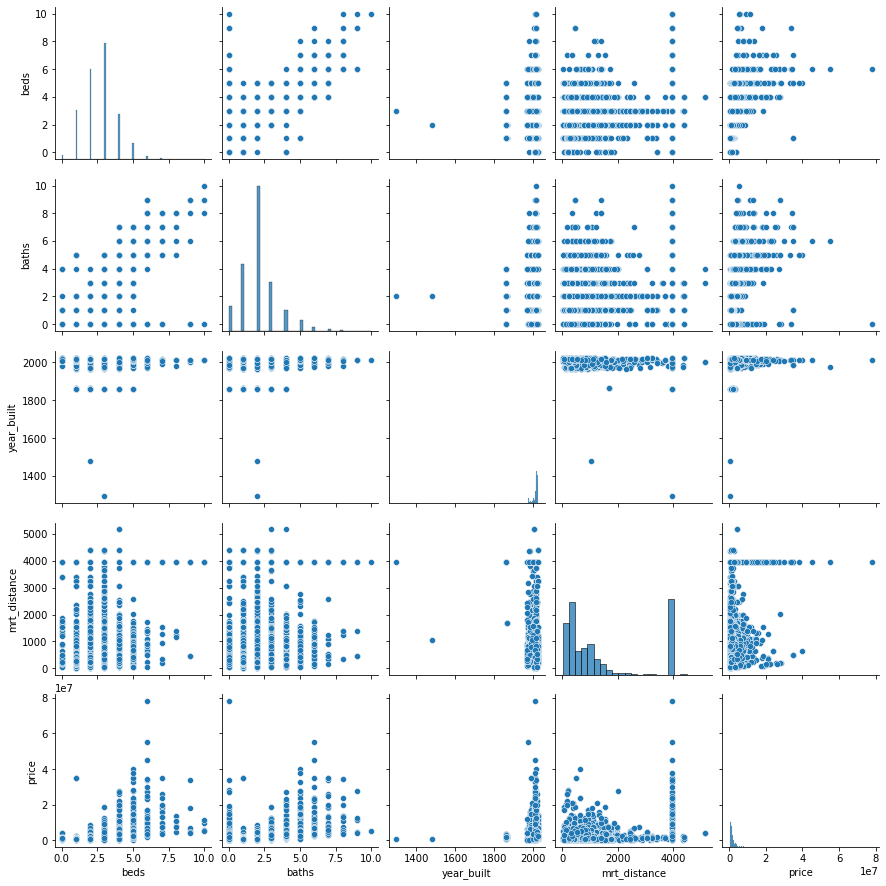

In [353]:
sns.pairplot(data_final)

#### Price vs porperty type

<AxesSubplot:xlabel='property_type', ylabel='price'>

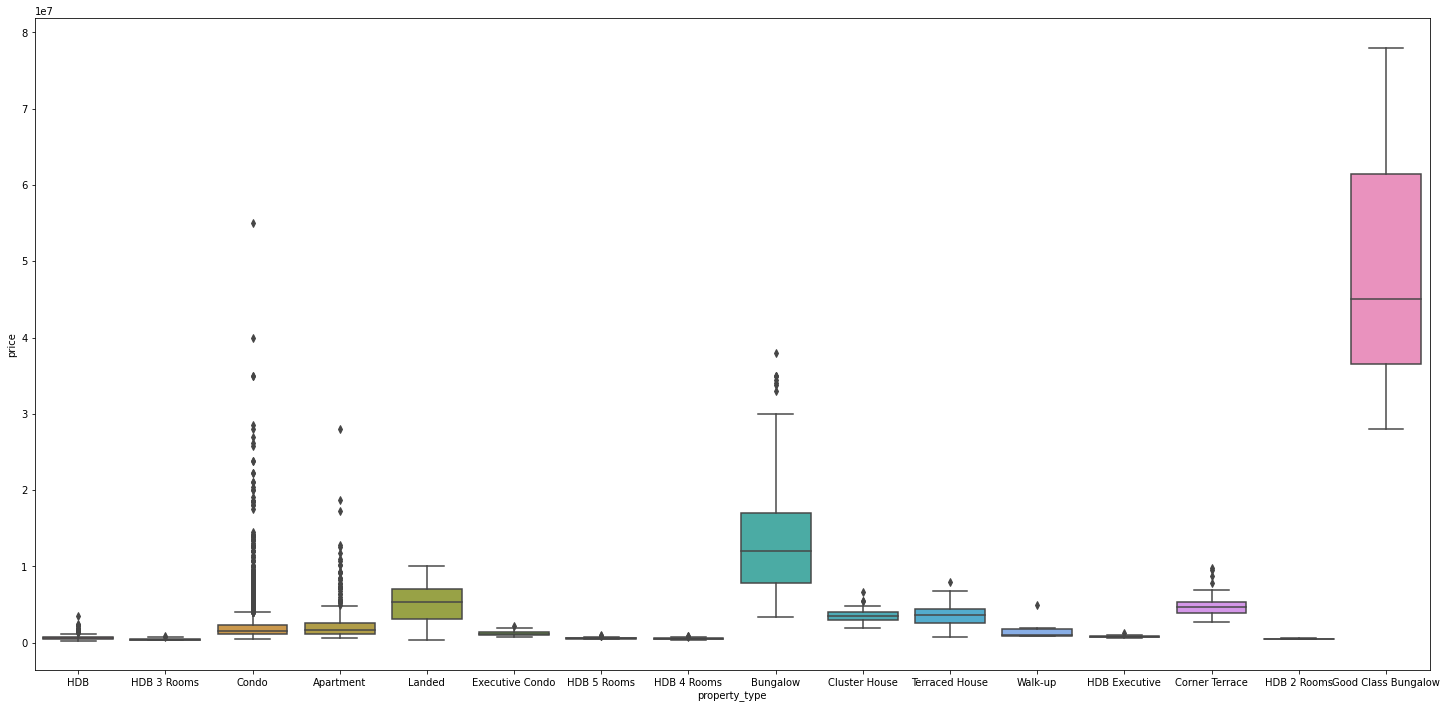

In [36]:
plt.figure(figsize=(25,12))
sns.boxplot(data=data_final,x='property_type',y='price')

#### Price vs address code

<AxesSubplot:xlabel='address_code', ylabel='price'>

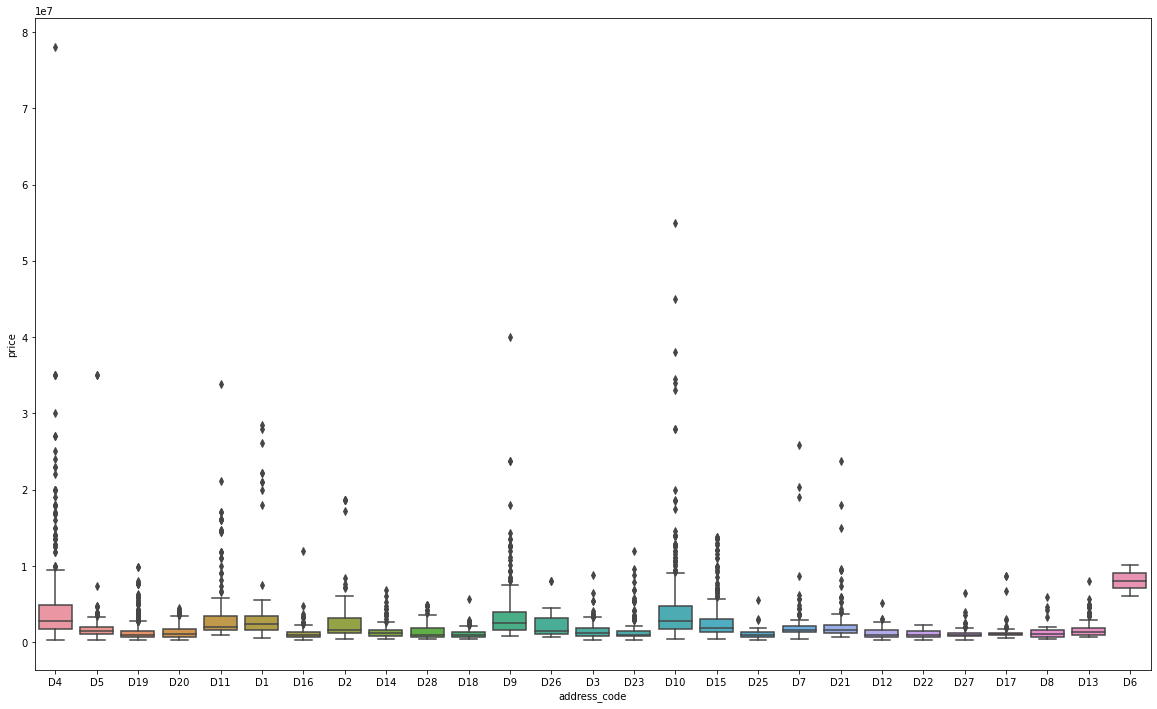

In [40]:
plt.figure(figsize=(20,12))
sns.boxplot(data=data_final,x='address_code',y='price')

##### Price vs sqft

<AxesSubplot:xlabel='sqft', ylabel='price'>

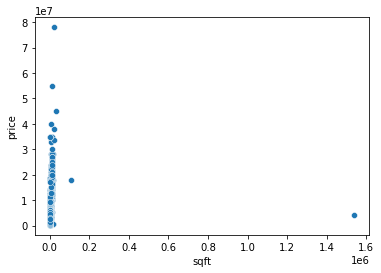

In [41]:
sns.scatterplot(data=data_final,x='sqft',y='price')

There is an anomaly for sqft

In [54]:
data_final['sqft'].sort_values().tail()

236      19869.0
816      20076.0
69       31000.0
100     107639.0
14     1539000.0
Name: sqft, dtype: float64

In [85]:
data_final[data_final['sqft']==1539000]

title address_code  beds  \
4214  4 Bed Condo for Sale in Irwell Hill Residences           D9     4   

      baths  year_built tenure property_type  mrt_distance       sqft  \
4214      3      2025.0     99         Condo        1540.0  1539000.0   

          price  
4214  4029000.0

In [91]:
data_final[data_final['sqft']==107639]

title address_code  beds  baths   year_built  \
3600  7 Bed House for Sale in Cove Way           D4     7      5  2009.921788   

      tenure property_type  mrt_distance      sqft       price  
3600  others      Bungalow   3855.488889  107639.0  18000000.0

Removing the anomalies

In [28]:
data_final.drop(index=4214,inplace=True)

In [29]:
data_final.drop(index=3600,inplace=True)

<AxesSubplot:xlabel='sqft', ylabel='price'>

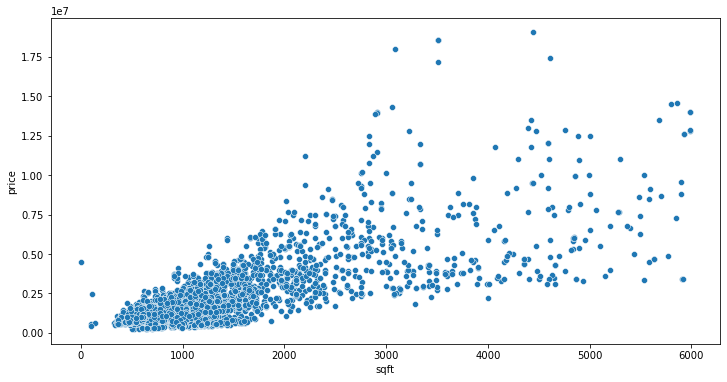

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=data_final[(data_final['sqft']<6000) & (data_final['price']<2e7)],x='sqft',y='price')

<AxesSubplot:xlabel='sqft', ylabel='price'>

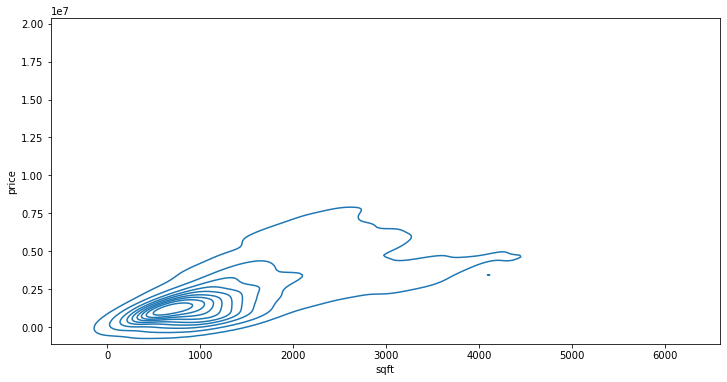

In [105]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=data_final[(data_final['sqft']<6000) & (data_final['price']<2e7)],x='sqft',y='price')

##### Price vs bedrooms

<AxesSubplot:xlabel='beds', ylabel='price'>

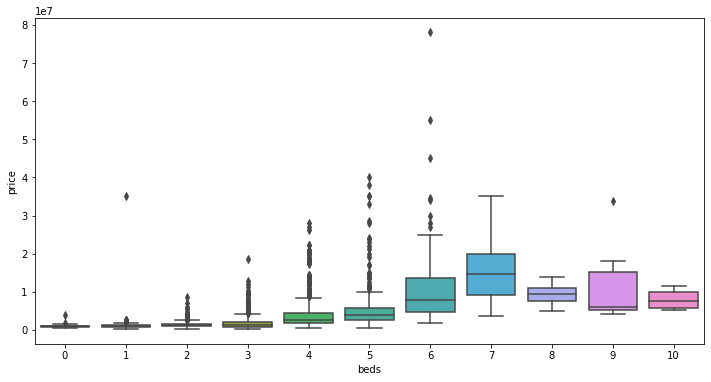

In [108]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data_final,x='beds',y='price')

#### Price vs bathrooms

<AxesSubplot:xlabel='baths', ylabel='price'>

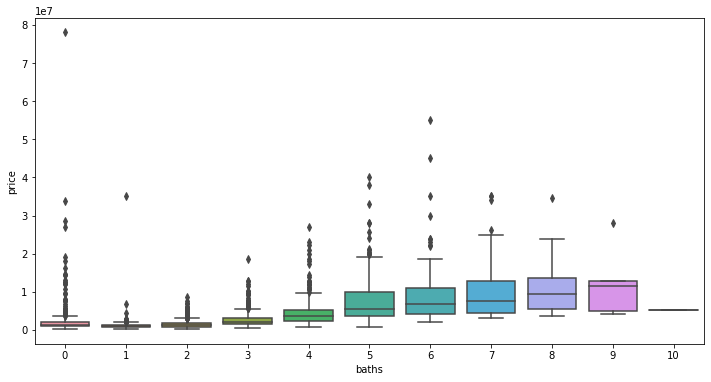

In [109]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data_final,x='baths',y='price')

#### Price vs year build

<AxesSubplot:xlabel='year_built', ylabel='price'>

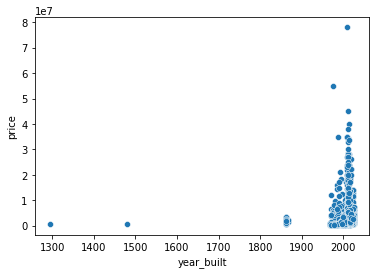

In [112]:
sns.scatterplot(data=data_final,x='year_built',y='price')

Removing the properties that were build in Sanilah Utama times.

In [31]:
data_final[data_final['year_built']<1800]

title address_code  beds  \
3476  HDB Flat for Sale in 91A Telok Blangah Street 31           D4     2   
3755         HDB Flat for Sale in 674B Yishun Avenue 4          D27     3   

      baths  year_built tenure property_type  mrt_distance    sqft     price  
3476      2      1480.0     99           HDB   1043.000000   732.0  650000.0  
3755      2      1294.0     99           HDB   3887.266667  1206.0  585000.0

In [32]:
data_final.drop(index=[3476,3755],inplace=True)

<AxesSubplot:xlabel='year_built', ylabel='price'>

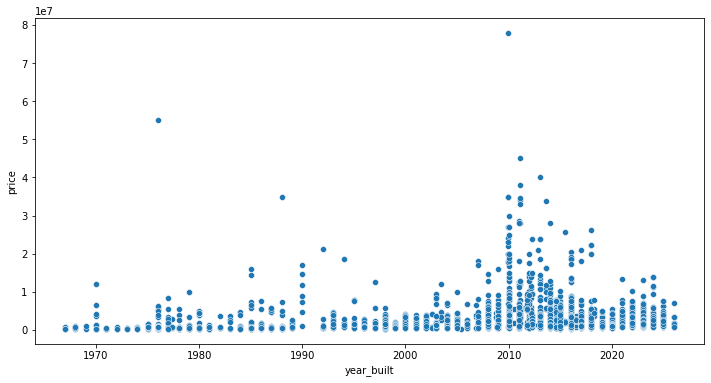

In [33]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=data_final[data_final['year_built']>1900],x='year_built',y='price')

In [28]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5097 entries, 0 to 7979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5097 non-null   object 
 1   address_code   5097 non-null   object 
 2   beds           5097 non-null   int64  
 3   baths          5097 non-null   int64  
 4   year_built     5097 non-null   float64
 5   tenure         5097 non-null   object 
 6   property_type  5097 non-null   object 
 7   mrt_distance   5097 non-null   float64
 8   sqft           5097 non-null   float64
 9   price          5097 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 438.0+ KB


##### We shall analyze properties that have a listing price of lower than 10 million to increase the accuracy of our model and perhaps create a separate model for properties more than 10 million.

In [34]:
data_final=data_final[data_final['price']<10000000]

Now we one-hot encode the address code, tenure and propety type

In [35]:
def tenure_cleaner(x):
    if x=='99':
        return int(x)
    elif x=='Freehold':
        return x
    else:
        return 'others'
data_final['tenure']=data_final['tenure'].apply(tenure_cleaner)

In [36]:
data_final['tenure'].value_counts()

99          3334
Freehold    1325
others       307
Name: tenure, dtype: int64

In [43]:
data_final['property_type'].value_counts()

Condo                  3508
HDB                     662
Apartment               323
Executive Condo         138
Bungalow                103
Terraced House           95
Corner Terrace           58
HDB 5 Rooms              57
HDB 4 Rooms              45
Cluster House            34
HDB 3 Rooms              31
HDB Executive            18
Landed                   14
Walk-up                   6
Good Class Bungalow       3
HDB 2 Rooms               2
Name: property_type, dtype: int64

Grouping up all the HDBs and condos and the remianing ones as landed property

In [37]:
def type_cleaner(x):
    if 'HDB' in x:
        return 'HDB'
    elif x=='Walk-up':
        return 'Apartment'
    elif x=='Condo' or x=='Executive Condo':
        return x
    else:
        return 'Landed'

data_final['property_type']=data_final['property_type'].apply(type_cleaner)

In [38]:
data_final['property_type'].value_counts()

Condo              3453
HDB                 815
Landed              554
Executive Condo     138
Apartment             6
Name: property_type, dtype: int64

In [39]:
categorical = ['address_code','tenure','property_type']
cat_feats = pd.get_dummies(data_final[categorical],columns=categorical,drop_first=True)

In [40]:
data_final=data_final.join(cat_feats,how='right')

In [41]:
data_final.drop(categorical,axis=1,inplace=True)

In [42]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 7979
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          4966 non-null   object 
 1   beds                           4966 non-null   int64  
 2   baths                          4966 non-null   int64  
 3   year_built                     4966 non-null   float64
 4   mrt_distance                   4966 non-null   float64
 5   sqft                           4966 non-null   float64
 6   price                          4966 non-null   float64
 7   address_code_D10               4966 non-null   uint8  
 8   address_code_D11               4966 non-null   uint8  
 9   address_code_D12               4966 non-null   uint8  
 10  address_code_D13               4966 non-null   uint8  
 11  address_code_D14               4966 non-null   uint8  
 12  address_code_D15               4966 non-null   u

#### I will log the price to scale it down for training

In [43]:
data_final['price']=data_final['price'].apply(lambda x: np.log10(x))

In [44]:
from sklearn.model_selection import train_test_split
X = data_final.drop(['price','title'],axis=1)
y=data_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)


### Scaling data

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)
X_train_scaled=pd.DataFrame(scaled_train,columns=X.columns)
X_test_scaled=pd.DataFrame(scaled_test,columns=X.columns)

In [46]:
X_train_scaled

beds  baths  year_built  mrt_distance      sqft  address_code_D10  \
0      0.7    0.6    0.916311      0.751602  0.265524               0.0   
1      0.5    0.3    0.945122      0.167248  0.142592               0.0   
2      0.2    0.2    0.878049      0.203488  0.047351               0.0   
3      0.2    0.2    0.981707      0.214147  0.036802               0.0   
4      0.3    0.2    0.951220      0.029264  0.092244               0.0   
...    ...    ...         ...           ...       ...               ...   
3967   0.1    0.1    0.926829      0.043217  0.029010               0.0   
3968   0.5    0.5    0.896341      0.751602  0.275474               0.0   
3969   0.3    0.2    0.981707      0.099806  0.056761               0.0   
3970   0.3    0.3    0.951220      0.029264  0.092244               0.0   
3971   0.3    0.0    0.939024      0.277132  0.061916               0.0   

      address_code_D11  address_code_D12  address_code_D13  address_code_D14  \
0                  0.0               0.0               0.0               0.0   
1                  0.0               0.0               0.0               0.0   
2                  0.0               0.0               0.0               0.0   
3                  0.0               0.0               0.0               0.0   
4                  0.0               0.0               0.0               0.0   
...                ...               ...               ...               ...   
3967               0.0               0.0               0.0               1.0   
3968               0.0               0.0               0.0               0.0   
3969               0.0               0.0               0.0               0.0   
3970               0.0               0.0               0.0               0.0   
3971               0.0               0.0               0.0               0.0   

      ...  address_code_D6  address_code_D7  address_code_D8  address_code_D9  \
0     ...              0.0              0.0              0.0              0.0   
1     ...              0.0              0.0              0.0              0.0   
2     ...              0.0              0.0              0.0              0.0   
3     ...              0.0              0.0              0.0              0.0   
4     ...              0.0              0.0              0.0              0.0   
...   ...              ...              ...              ...              ...   
3967  ...              0.0              0.0              0.0              0.0   
3968  ...              0.0              0.0              0.0              0.0   
3969  ...              0.0              0.0              0.0              1.0   
3970  ...              0.0              0.0              0.0              0.0   
3971  ...              0.0              0.0              0.0              0.0   

      tenure_Freehold  tenure_others  property_type_Condo  \
0                 0.0            1.0                  0.0   
1                 0.0            0.0                  1.0   
2                 1.0            0.0                  1.0   
3                 1.0            0.0                  1.0   
4                 0.0            0.0                  1.0   
...               ...            ...                  ...   
3967              1.0            0.0                  1.0   
3968              0.0            0.0                  1.0   
3969              1.0            0.0                  1.0   
3970              0.0            0.0                  1.0   
3971              0.0            0.0                  0.0   

      property_type_Executive Condo  property_type_HDB  property_type_Landed  
0                               0.0                0.0                   1.0  
1                               0.0                0.0                   0.0  
2                               0.0                0.0                   0.0  
3                               0.0                0.0                   0.0  
4                               0.0        

## Model building 

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, LeakyReLU

model = Sequential()

model.add(Dense(36))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(18))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(9))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(X_train_scaled,y_train,epochs=1000,verbose=1,validation_split=0.2,batch_size=128)


Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 30.9751 - val_loss: 18.3820
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 13.7794 - val_loss: 2.0327
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 4.2703 - val_loss: 0.9220
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 3.7617 - val_loss: 0.8990
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 3.4138 - val_loss: 0.6155
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 3.2501 - val_loss: 0.4842
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.8367 - val_loss: 0.4077
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.8594 - val_loss: 0.3841
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.7385 - val_loss: 0.3193
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.5246 - val_loss: 0.3

25/25 [==============================] - 0s 2ms/step - loss: 0.5819 - val_loss: 0.0310
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5706 - val_loss: 0.0323
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5753 - val_loss: 0.0282
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5638 - val_loss: 0.0462
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5805 - val_loss: 0.0351
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5610 - val_loss: 0.0353
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5117 - val_loss: 0.0208
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5832 - val_loss: 0.0345
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5771 - val_loss: 0.0219
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5332 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1190 - val_loss: 0.0134
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1230 - val_loss: 0.0116
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1114 - val_loss: 0.0115
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1225 - val_loss: 0.0113
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1180 - val_loss: 0.0119
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1225 - val_loss: 0.0128
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1149 - val_loss: 0.0152
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1099 - val_loss: 0.0140
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.0128
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1131 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0087
Epoch 483/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0088
Epoch 484/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0092
Epoch 485/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0089
Epoch 486/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0090
Epoch 487/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0089
Epoch 488/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0087
Epoch 489/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0086
Epoch 490/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0087
Epoch 491/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0080
Epoch 643/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0085
Epoch 644/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0086
Epoch 645/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 646/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0081
Epoch 647/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0079
Epoch 648/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0079
Epoch 649/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0077
Epoch 650/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0080
Epoch 651/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 803/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 804/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 805/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 806/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0071
Epoch 807/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 808/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0076
Epoch 809/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 810/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0072
Epoch 811/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0066
Epoch 963/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 964/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 965/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0067
Epoch 966/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0067
Epoch 967/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0067
Epoch 968/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 969/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 970/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0070
Epoch 971/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.

<AxesSubplot:>

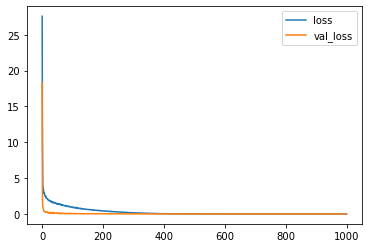

In [47]:
pd.DataFrame(model.history.history).plot()

## Model Evaluation

In [50]:
pred= model.predict(X_test_scaled)
mean_squared_error(pred,y_test)

0.006859255490499756

In [55]:
model.save('price_recommender.h5')

### Testing model by going on 99.co/singapore to find new random listing

In [53]:
#Random new listing posted on 21 May 2021: https://www.99.co/singapore/sale/property/rv-residences-condo-sBf7kkEtUiAa7qW9FqBdpa?enquiry_position=18&enquiry_source=Search
random_data = [2,2,2014,20,861,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0]
random=scaler.transform(np.reshape(random_data,(-1,37)))
predicted = 10**(model.predict(random))
predicted #Actual is 1,790,000

array([[1626160.9]], dtype=float32)

Model worked well where suggested price is quite close to the listed price.